In [1]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from smart_open import smart_open
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from nltk.corpus import stopwords
import os, codecs
%matplotlib inline
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords

2017-04-06 21:11:26,214 : INFO : 'pattern' package found; tag filters are available for English
/usr/lib64/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
class MySentences(object):
    def __init__(self, dirname):
        self.dirname = dirname
 
    def __iter__(self):
        for fname in os.listdir(self.dirname):
            for line in codecs.open(os.path.join(self.dirname, fname)) :
                yield line.split()

In [3]:
sentences = MySentences('/home/bahbbc/Documents/teste-personalidade') # a memory-friendly iterator

In [4]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
num_features = 300
min_word_count = 1   # Minimum word count                        
num_workers = 40       # Number of threads to run in parallel
context = 10          # Context window size             


In [5]:
model = gensim.models.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, window = context)

2017-04-06 21:11:32,929 : INFO : collecting all words and their counts
2017-04-06 21:11:33,353 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-04-06 21:11:33,644 : INFO : PROGRESS: at sentence #10000, processed 128109 words, keeping 54940 word types
2017-04-06 21:11:33,699 : INFO : PROGRESS: at sentence #20000, processed 251201 words, keeping 99640 word types
2017-04-06 21:11:33,747 : INFO : PROGRESS: at sentence #30000, processed 358077 words, keeping 140417 word types
2017-04-06 21:11:33,811 : INFO : PROGRESS: at sentence #40000, processed 472849 words, keeping 180861 word types
2017-04-06 21:11:33,861 : INFO : PROGRESS: at sentence #50000, processed 569472 words, keeping 217380 word types
2017-04-06 21:11:33,915 : INFO : PROGRESS: at sentence #60000, processed 677975 words, keeping 256516 word types
2017-04-06 21:11:33,975 : INFO : PROGRESS: at sentence #70000, processed 782725 words, keeping 292990 word types
2017-04-06 21:11:34,029 : INFO : PROGRESS

MemoryError: 

In [ ]:
model.save_word2vec_format('/run/media/bahbbc/My Passport/tweets_models/model_1')

In [5]:
model = gensim.models.Word2Vec.load_word2vec_format('/home/bahbbc/Documents/personality_norm', encoding='utf8', unicode_errors='ignore')
#model = Word2Vec.load_word2vec_format('/home/bahbbc/Documents/teste-personalidade/personality_1',binary=True)
model.init_sims(replace=True)

2017-03-04 11:21:25,745 : INFO : loading projection weights from /home/bahbbc/Documents/personality_norm


EOFError: unexpected end of input; is count incorrect or file otherwise damaged?

In [6]:
print(model.most_similar(positive=['gato', 'cachorro']))

2017-03-04 20:12:54,823 : INFO : precomputing L2-norms of word weight vectors


[('bicho', 0.838931679725647), ('bagulho', 0.8338598608970642), ('fusca', 0.8252264261245728), ('vizinho', 0.8179534673690796), ('garoto', 0.8105221390724182), ('cabelo', 0.8087266087532043), ('filhote', 0.801296591758728), ('cachorrinho', 0.7989997267723083), ('brinquedo', 0.7961611747741699), ('menino', 0.796120285987854)]


### Verify model with personality

In [7]:
df = pd.read_csv('~/personality-normalized-word2vec-norm.csv', encoding='utf_8')

In [51]:
df.extraversion_m.value_counts()

0    529
1    510
Name: extraversion_m, dtype: int64

In [52]:
train_w2v_data, test_w2v_data = train_test_split(df, test_size=0.3, random_state=42)

### Evaluation code

In [53]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    target_names = ['no', 'yes']
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [54]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

In [55]:
def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['formatted_text'])
    predictions = classifier.predict(data_features)
    target = data['extraversion_m']
    evaluate_prediction(predictions, target)

### Word2Vec model training

In [56]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.wv.vocab:
            mean.append(wv.wv.syn0norm[wv.wv.vocab[word].index])
            all_words.add(wv.wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(num_features,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list ])

In [57]:

def w2v_tokenize_text(text):
    tokens = []
    if text is np.nan:
        return []
    if type(text) == float:
        return []
    for sent in nltk.sent_tokenize(text, language='portuguese'):
        for word in nltk.word_tokenize(sent, language='portuguese'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [58]:
test_tokenized = test_w2v_data.apply(lambda r: w2v_tokenize_text(r['formatted_text']), axis=1).values
train_tokenized = train_w2v_data.apply(lambda r: w2v_tokenize_text(r['formatted_text']), axis=1).values

In [59]:
%%time
X_train_word_average = word_averaging_list(model,train_tokenized)
X_test_word_average = word_averaging_list(model,test_tokenized)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:7: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
2017-03-05 15:28:48,726 : WARNING : cannot compute similarity with no input [u'FOREIGN']
2017-03-05 15:28:49,169 : WARNING : cannot compute similarity with no input []
2017-03-05 15:28:49,522 : WARNING : cannot compute similarity with no input []
2017-03-05 15:28:49,528 : WARNING : cannot compute similarity with no input []
2017-03-05 15:28:50,228 : WARNING : cannot compute similarity with no input []
2017-03-05 15:28:50,492 : WARNING : cannot compute similarity with no input []
2017-03-05 15:28:50,908 : WARNING : cannot compute similarity with no input [u'FOREIGN', u'FOREIGN', u'FOREIGN']
2017-03-05 15:28:50,925 : WARNING : cannot compute similarity with no input []
2017-03-05 15:28:51,732 : WARNING : cannot compute similarity with no input []
2017-03-05 15:28:51,830 : WARNING : cannot compute similarity wit

CPU times: user 4.42 s, sys: 23.2 ms, total: 4.44 s
Wall time: 4.44 s


In [60]:
%%time
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)

logreg = logreg.fit(X_train_word_average, train_data['extraversion_m'])
predicted = logreg.predict(X_test_word_average)

CPU times: user 1.36 s, sys: 850 µs, total: 1.36 s
Wall time: 1.37 s


accuracy 0.605769230769
confusion matrix
 [[ 87  55]
 [ 68 102]]
(row=expected, col=predicted)


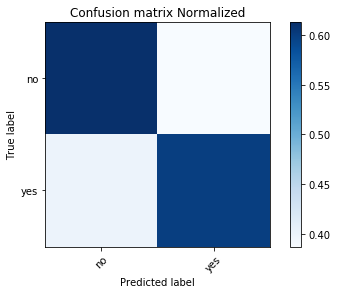

In [61]:
evaluate_prediction(predicted, test_data.extraversion_m)

## Remove stop words

In [63]:
def w2v_tokenize_text(text):
    tokens = []
    if text is np.nan:
        return []
    if type(text) == float:
        return []
    for sent in nltk.sent_tokenize(text, language='portuguese'):
        for word in nltk.word_tokenize(sent, language='portuguese'):
            if len(word) < 2:
                continue
            if word in stopwords.words('portuguese'):
                continue
            tokens.append(word)
    return tokens

In [64]:
test_tokenized = test_w2v_data.apply(lambda r: w2v_tokenize_text(r['formatted_text']), axis=1).values
train_tokenized = train_w2v_data.apply(lambda r: w2v_tokenize_text(r['formatted_text']), axis=1).values

In [65]:
%%time
X_train_word_average = word_averaging_list(model,train_tokenized)
X_test_word_average = word_averaging_list(model,test_tokenized)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:7: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
2017-03-05 15:34:40,882 : WARNING : cannot compute similarity with no input [u'FOREIGN']
2017-03-05 15:34:41,236 : WARNING : cannot compute similarity with no input []
2017-03-05 15:34:41,554 : WARNING : cannot compute similarity with no input []
2017-03-05 15:34:41,559 : WARNING : cannot compute similarity with no input []
2017-03-05 15:34:42,024 : WARNING : cannot compute similarity with no input [u'FOREIGN', u'NAME', u'NAME', u'NAME', u'NAME', u'NAME']
2017-03-05 15:34:42,150 : WARNING : cannot compute similarity with no input []
2017-03-05 15:34:42,345 : WARNING : cannot compute similarity with no input []
2017-03-05 15:34:42,646 : WARNING : cannot compute similarity with no input [u'FOREIGN', u'FOREIGN', u'FOREIGN']
2017-03-05 15:34:42,662 : WARNING : cannot compute similarity with no input []
2017-03-05

CPU times: user 3.63 s, sys: 23.7 ms, total: 3.65 s
Wall time: 3.72 s


In [66]:
%%time
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)

logreg = logreg.fit(X_train_word_average, train_w2v_data['extraversion_m'])
predicted = logreg.predict(X_test_word_average)

CPU times: user 1.38 s, sys: 889 µs, total: 1.38 s
Wall time: 1.38 s


accuracy 0.586538461538
confusion matrix
 [[85 57]
 [72 98]]
(row=expected, col=predicted)


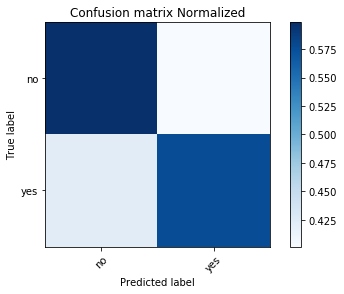

In [67]:
evaluate_prediction(predicted, test_w2v_data.extraversion_m)

Fitting a random forest to labeled training data...
accuracy 0.586538461538
confusion matrix
 [[92 50]
 [79 91]]
(row=expected, col=predicted)


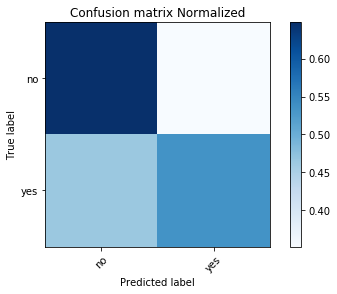

In [79]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier( n_estimators = 100, random_state = 42 )

print "Fitting a random forest to labeled training data..."
forest = forest.fit( X_train_word_average, train_w2v_data["extraversion_m"] )

# Test & extract results 
result = forest.predict( X_test_word_average )

evaluate_prediction(result, test_w2v_data.extraversion_m)

## Doc2Vec

In [69]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [70]:

def tokenize_text(text):
    tokens = []
    if text is np.nan:
        return []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [71]:
train_tagged = train_w2v_data.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['formatted_text']), tags=[r.extraversion_m]), axis=1)

In [72]:
test_tagged = test_w2v_data.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['formatted_text']), tags=[r.extraversion_m]), axis=1)

In [73]:
%%time
trainsent = train_tagged.values
testsent = test_tagged.values

# simple gensim doc2vec api
doc2vec_model = Doc2Vec(trainsent, workers=1, size=5, iter=20, dm=1)

train_targets, train_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in trainsent])

2017-03-05 15:35:38,422 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2017-03-05 15:35:38,424 : INFO : collecting all words and their counts
2017-03-05 15:35:38,425 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2017-03-05 15:35:38,781 : INFO : collected 43446 word types and 2 unique tags from a corpus of 727 examples and 1472087 words
2017-03-05 15:35:38,782 : INFO : Loading a fresh vocabulary
2017-03-05 15:35:38,841 : INFO : min_count=5 retains 13634 unique words (31% of original 43446, drops 29812)
2017-03-05 15:35:38,841 : INFO : min_count=5 leaves 1421890 word corpus (96% of original 1472087, drops 50197)
2017-03-05 15:35:38,874 : INFO : deleting the raw counts dictionary of 43446 items
2017-03-05 15:35:38,876 : INFO : sample=0.001 downsamples 46 most-common words
2017-03-05 15:35:38,877 : INFO : downsampling leaves estimated 1039507 word corpus (73.1% of prior 1421890)
2017-03-05 15:35:38,878 : INFO : estimated

CPU times: user 57.7 s, sys: 245 ms, total: 58 s
Wall time: 58.5 s


In [74]:
%%time
test_targets, test_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in testsent])

CPU times: user 10.1 s, sys: 551 µs, total: 10.1 s
Wall time: 10.1 s


accuracy 0.570512820513
confusion matrix
 [[106  36]
 [ 98  72]]
(row=expected, col=predicted)


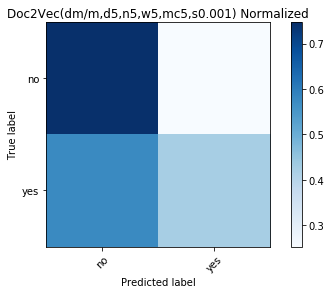

In [75]:
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_regressors, train_targets)
evaluate_prediction(logreg.predict(test_regressors), test_targets, title=str(doc2vec_model))

2017-03-05 15:36:47,380 : INFO : precomputing L2-norms of doc weight vectors


accuracy 0.576923076923
confusion matrix
 [[83 59]
 [73 97]]
(row=expected, col=predicted)
CPU times: user 184 ms, sys: 156 ms, total: 340 ms
Wall time: 178 ms


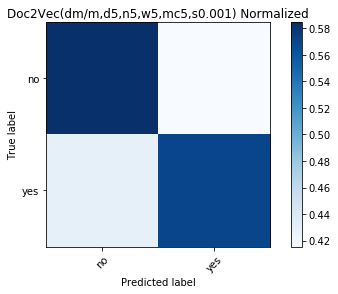

In [76]:
%%time 
knn_test_predictions = [
    doc2vec_model.docvecs.most_similar([pred_vec], topn=1)[0][0]
    for pred_vec in test_regressors
]
evaluate_prediction(knn_test_predictions, test_targets, str(doc2vec_model))

Fitting a random forest to labeled training data...
accuracy 0.532051282051
confusion matrix
 [[88 54]
 [92 78]]
(row=expected, col=predicted)


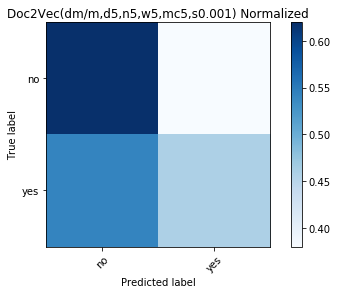

In [78]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier( n_estimators = 100, random_state = 42 )

print "Fitting a random forest to labeled training data..."
forest = forest.fit( train_regressors, train_w2v_data["extraversion_m"] )

# Test & extract results 
result = forest.predict( test_regressors )

evaluate_prediction(result, test_targets, str(doc2vec_model))